# "Multi Label Classification with fastai"
> "In this post we'll be working with the fastai library in a multi label classification task on the Planets dataset"

- toc: true
- branch: master
- badges: true
- author: João Marcelo Tozato
- image: images/sat.png
- categories: [fastai, multilabel, classification]

### Imports

In [ ]:
#hide
#Run once per session
!pip install fastai wwf -q --upgrade

In [1]:
from fastai.vision.all import *

import pandas as pd

import torch
from torch import nn

from fastcore.meta import use_kwargs_dict

from fastai.callback.fp16 import to_fp16
from fastai.callback.progress import ProgressCallback
from fastai.callback.schedule import lr_find, fit_one_cycle

from fastai.data.block import MultiCategoryBlock, DataBlock
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import RandomSplitter, ColReader

from fastai.metrics import accuracy_multi, BaseLoss

from fastai.vision.augment import aug_transforms
from fastai.vision.data import ImageBlock
from fastai.vision.learner import cnn_learner

from torchvision.models import resnet34

### Getting the data

For this multi-label problem, we will use the Planet dataset, where it's a collection of satellite images with multiple labels describing the scene. I'll go through and explain a few different ways to make this dataset, highlighting some of the flexibility the new `DataBlock` API can do. 

First, let's grab our data

In [2]:
planet_source = untar_data(URLs.PLANET_SAMPLE)
df = pd.read_csv(planet_source/'labels.csv')

Now let's look at how it's stored. Our `DataFrame` is formatted so our images filename is the **first** column, and the labels in the **second**

In [3]:
df.head()

,image_name,tags
0,train_21983,partly_cloudy primary
1,train_9516,clear cultivation primary water
2,train_12664,haze primary
3,train_36960,clear primary
4,train_5302,haze primary road


Note: due to some class imbalance issues, there is only one instance of the tag `blow_down`. As a result we will drop it since there is just one and oversampling would not make sense in this case:

In [4]:
df = df[df['tags'] != 'blow_down clear primary road']

### First Method -> DataBlock

In [5]:
batch_tfms = aug_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [6]:
planet = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=ColReader(0, pref=f'{planet_source}/train/', suff='.jpg'),
                   splitter=RandomSplitter(),
                   get_y=ColReader(1, label_delim=' '),
                   batch_tfms = batch_tfms)

* Multi-label so we want a `MultiCategoryBlock`
* `get_x` and `get_y` define how we expect to grab our data
* `ColReader` works with Pandas `DataFrames`

Now we can dataloaders by passing in our source folder

In [7]:
dls = planet.dataloaders(df)

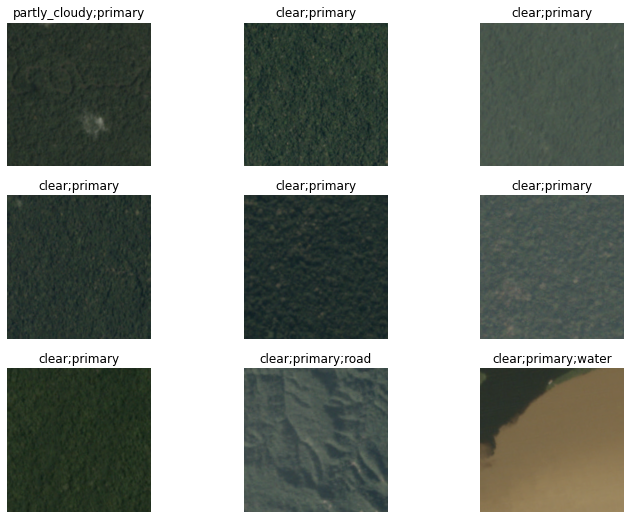

In [8]:
dls.show_batch(max_n=9, figsize=(12,9))

### Second Method -> Lambda Functions

This next version will instead use `lambda` functions to grab our image names, which get's rid of the `ColReader`, if you're more familiar with these

In [9]:
blocks = (ImageBlock, MultiCategoryBlock)

First let's try our `get_x`. Our lambda function needs to return a `Path()` to our particular image. This can be done by including `f'{x[0]}.jpg'` 

But what is that even doing? Let's take a look

In [10]:
get_x = lambda x:planet_source/'train'/f'{x[0]}.jpg'

If we pass in one row of our `DataFrame`, we should expect to see the entire path laid out in front of us!

In [11]:
val = df.values[0]; val

array(['train_21983', 'partly_cloudy primary'], dtype=object)

In [12]:
get_x(df.values[0])

Path('/home/jmtzt/.fastai/data/planet_sample/train/train_21983.jpg')

Which it does! A nice, simple, and *clean* way to grab our paths. Let's see how our `y` getter will look like

In [13]:
get_y = lambda x:x[1].split(' ')

Looks fairly close to the previous version, if you pay attention. Remember that our `x` is the `DataFrame`'s values, so if we grab position 1 from earlier, we can see that it's our labels!

Let's make our full `PipeLine` now that we're sure everything will work

In [14]:
planet = DataBlock(blocks=blocks,
                   get_x=get_x,
                   splitter=RandomSplitter(),
                   get_y=get_y,
                   batch_tfms=batch_tfms)

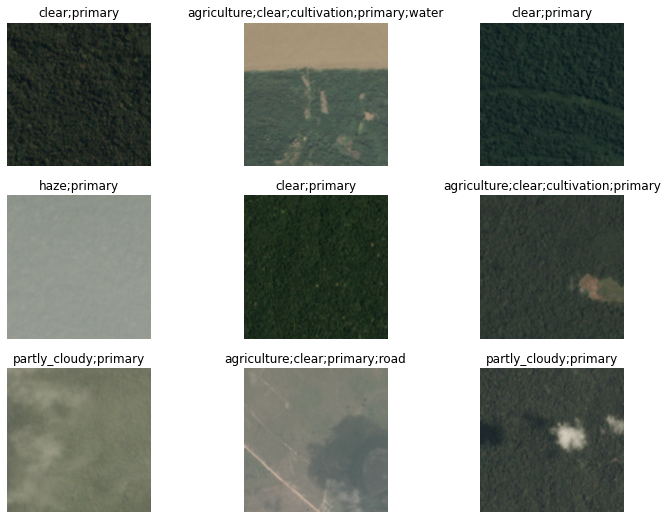

In [15]:
dls = planet.dataloaders(df)
dls.show_batch(max_n=9, figsize=(12,9))

### Third Method -> Custom `get_items` Functions

That previous one worked fine, but shouldn't I be able to do a one-liner? Since it's all right there instead of defining our `get_x` and `get_y`? There *IS*! We can create our own function, where we should expect to return both an `x` and a `y` value. Let's make one 

In [6]:
def _planet_items(x): return (
    f'{planet_source}/train/'+x.image_name+'.jpg', x.tags.str.split())

Our `DataBlock` now looks like so:

In [7]:
planet = DataBlock.from_columns(blocks=(ImageBlock, MultiCategoryBlock),
                   get_items = _planet_items, 
                   splitter=RandomSplitter(),
                   batch_tfms=batch_tfms)

That's all our `DataBlock` needs if we can plan accordingly. Looks pretty clean!

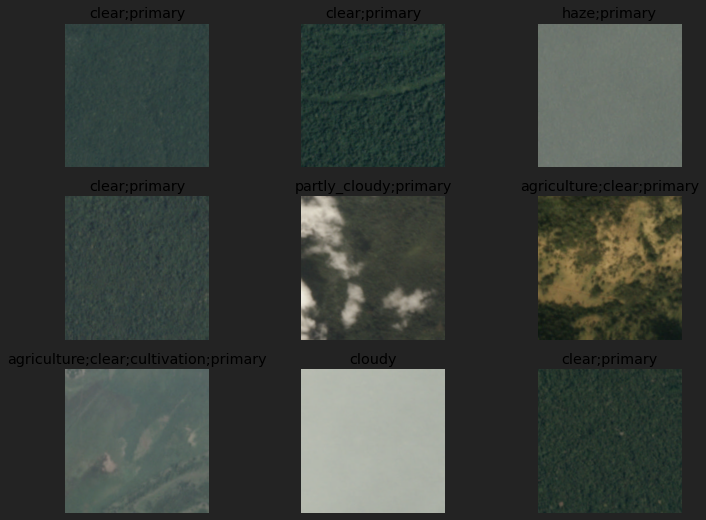

In [8]:
dls = planet.dataloaders(df)
dls.show_batch(max_n=9, figsize=(12,9))

### Training a model

We'll use a `resnet34` for this task and the `accuracy_multi` metric

In [9]:
from torchvision.models import resnet34
from fastai.metrics import accuracy_multi

In [10]:
learn = cnn_learner(dls, resnet34, pretrained=True, metrics=[accuracy_multi])

Model results are on a scale with a threshold instead of exact, allows for "it's not any" due to a sigmoid activation in the loss function

In [11]:
class BCEWithLogitsLossFlat(BaseLoss):
    "Same as `nn.BCEWithLogitsLoss`, but flattens input and target."
    @use_kwargs_dict(keep=True, weight=None, reduction='mean', pos_weight=None)
    def __init__(self, *args, axis=-1, floatify=True, thresh=0.5, **kwargs):
        if kwargs.get('pos_weight', None) is not None and kwargs.get('flatten', None) is True:
            raise ValueError("`flatten` must be False when using `pos_weight` to avoid a RuntimeError due to shape mismatch")
        if kwargs.get('pos_weight', None) is not None: kwargs['flatten'] = False
        super().__init__(nn.BCEWithLogitsLoss, *args, axis=axis, floatify=floatify, is_2d=False, **kwargs)
        self.thresh = thresh

    def decodes(self, x):    return x>self.thresh
    def activation(self, x): return torch.sigmoid(x)

In [12]:
learn.loss_func = BCEWithLogitsLossFlat()

We'll find a good learning rate

SuggestedLRs(lr_min=0.03019951581954956, lr_steep=0.03981071710586548)

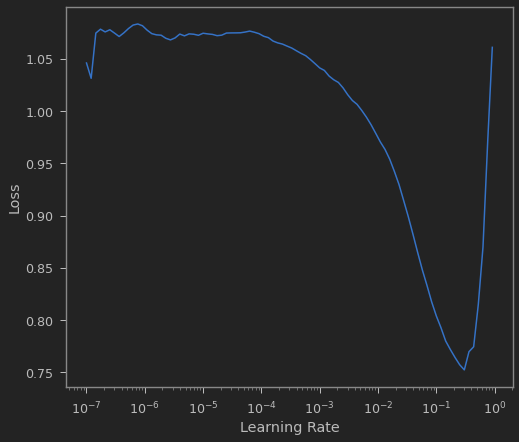

In [13]:
learn.lr_find()

And train! (we'll also used mixed precision too!)

In [14]:
lr = 1e-2
learn = learn.to_fp16()

In [15]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.924233,0.760086,0.632852,00:04
1,0.705390,0.285141,0.915201,00:03
2,0.500431,0.178712,0.935930,00:03
3,0.383179,0.177389,0.935930,00:03
4,0.314030,0.172159,0.935930,00:03


Great! Let's save and `unfreeze` to train the rest of our model!

In [16]:
learn.save('stage-1')

Path('models/stage-1.pth')

SuggestedLRs(lr_min=3.981071640737355e-05, lr_steep=9.12010818865383e-07)

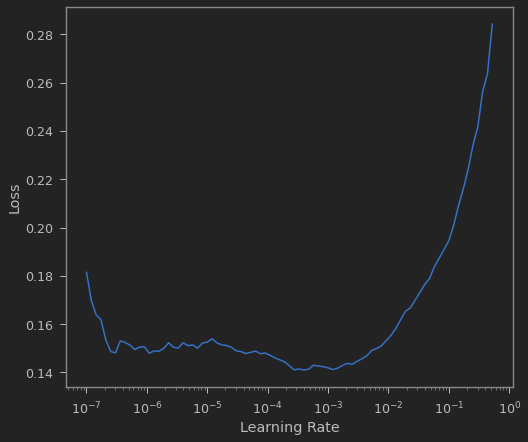

In [17]:
learn.unfreeze()
learn.lr_find()

We can now go through and use a learning rate around 1e-5 or so, and then have an ending learning rate five times smaller than our starting

In [71]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.163868,0.154094,0.944095,00:03
1,0.148674,0.138503,0.947864,00:03
2,0.138569,0.137463,0.949121,00:03
3,0.128286,0.141320,0.945980,00:03
4,0.121801,0.138059,0.948807,00:03


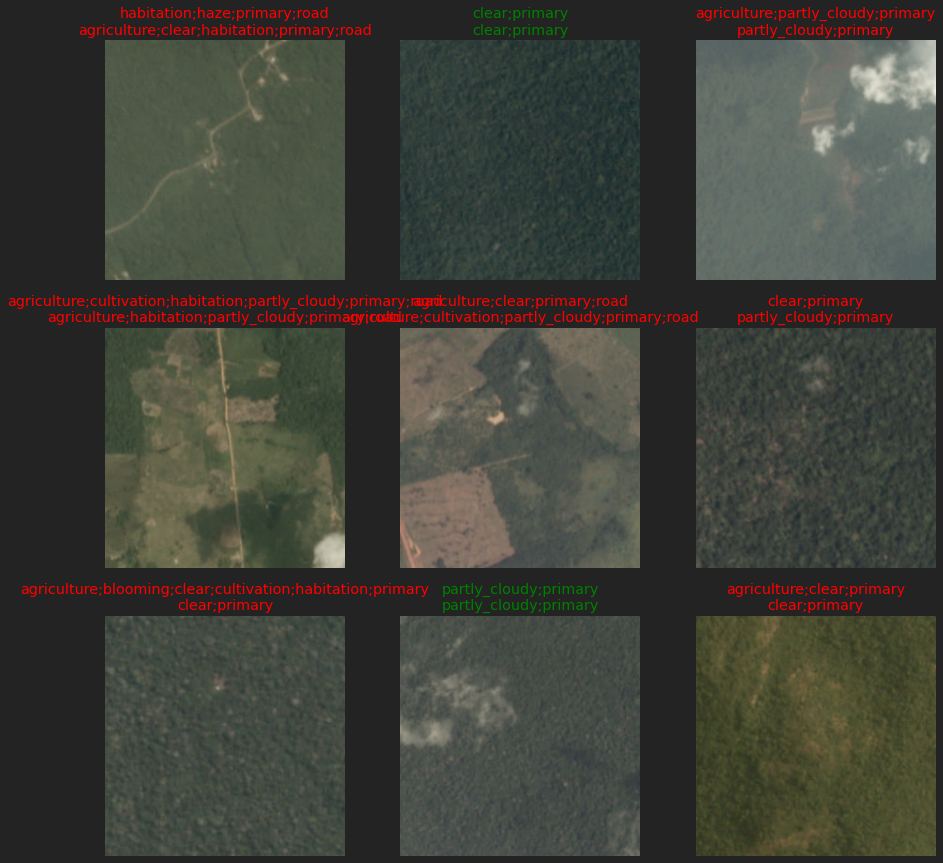

In [72]:
learn.show_results(figsize=(15,15))